# Setting up the agent 



In [1]:
# set OpenAI key
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [2]:
# setting up the translator and editor
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 
# llm_edit = ChatOpenAI(model="gpt-4o", temperature=0) 

In [3]:
# tracing the workflow
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

# Exercise 0: Simple chatbot

Building an agent to chat with.

In [7]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [8]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

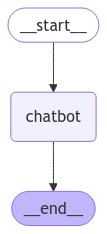

In [9]:
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: As of October 2023, the state of structural health monitoring (SHM) for static concrete bridges has advanced significantly, driven by technological innovations, increased awareness of infrastructure safety, and regulatory requirements. Here’s a high-level overview of the current landscape:

### 1. **Technological Advancements**
- **Sensor Technologies**: The use of various sensors, including strain gauges, accelerometers, displacement transducers, and temperature sensors, has become commonplace. These sensors are often integrated into the bridge structure to provide real-time data on performance and condition.
- **Wireless Monitoring**: Wireless sensor networks (WSNs) have gained traction, allowing for easier installation and maintenance, as well as reducing the need for extensive wiring.
- **Drones and UAVs**: Unmanned aerial vehicles (UAVs) are increasingly used for visual inspections and to collect data on hard-to-reach areas, enhancing the efficiency of monitoring effort

# Exercise 1: Single-Agent task execution

Building one agent that creates a summary by extracting key information.


In [23]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    data: str
    key_details: str
    sentiment: str
    article: str

graph_builder = StateGraph(State)

In [24]:
path_to_text = "../data/input/news_articles/article1.txt"

with open(path_to_text, 'r') as f:
    data = f.read()

# print(data)


In [25]:
def key_details(state: State):
    prompt = f'''
    Extract relevant information from the following news article: [{state["data"]}]. Please return a list of extracted key
    details in the format: ['topic1', 'topic2', 'author', 'date', 'location', ...]. Only include one instance of each detail, and
    prioritize accuracy over brevity. If multiple sources report conflicting information, please indicate this in your output.

    **Example Output Format:**

    * Each topic should be represented as a unique string (e.g., "COVID-19 pandemic", "global economy", etc.)
    * The author's name should be included if present
    * Date and location should be included if explicitly stated
    * Other relevant details (such as organization, event, or policy) can also be extracted

    **Constraints:**

    * Only extract information that is verifiable through primary sources
    * Avoid making inferences or assumptions beyond what is explicitly stated in the article
    * Prioritize accuracy over brevity; do not omit essential details for the sake of concision"
    '''
    state["key_details"] = llm.invoke(prompt)
    return state
    
def sentiment(state: State):
    prompt = f"""
    Perform a sentiment analysis on the following news article: [{state["data"]}].
    Classify the data to either of the following options: positive, negative or neutral.
    """
    state["sentiment"] = llm.invoke(prompt)
    return state

def write_summary(state: State):
    prompt = f"""
    Write a coherent summary of approximately 100 words of a news article using the following key details: {state["key_details"]}.
    Start of your summary with the sentiment of the article which is {state["sentiment"]}.
    """
    state["article"] = llm.invoke(prompt)
    return state


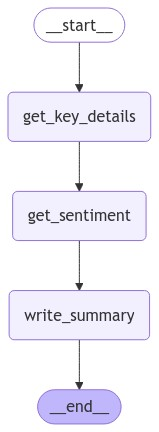

In [27]:
graph_builder.add_node("get_key_details", key_details)
graph_builder.add_node("get_sentiment", sentiment)
graph_builder.add_node("write_summary", write_summary)

graph_builder.add_edge(START, "get_key_details")
graph_builder.add_edge("get_key_details", "get_sentiment")
graph_builder.add_edge("get_sentiment", "write_summary")
graph_builder.add_edge("write_summary", END)

graph = graph_builder.compile()

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [29]:
graph.invoke({"data": data})

{'data': 'NOS Nieuws•\nvandaag, 12:11\nMeer ziekenhuizen in financiële problemen, bedreigt uitvoering Zorgakkoord\n\nDe ziekenhuizen in Nederland halen nog maar net een financiële voldoende waardoor ze nog niet in de problemen komen. Maar de noodzakelijke investeringsruimte ontbreekt om de grote hervormingen, zoals die in het Integraal Zorgakkoord (IZA) zijn afgesproken, tot een succes te maken. Dat concludeert accountantskantoor BDO in zijn jaarlijkse rapportage over de financiële situatie van de ziekenhuissector.\n\nVan de 60 onderzochte algemene ziekenhuizen scoren er 35 over het jaar 2023 een voldoende. In 2022 waren dat er nog 55. BDO benadrukt dat de kwaliteit van zorg niet ondermaats is, het gaat om het financiële plaatje.\n\nHet gemiddelde rapportcijfer voor algemene ziekenhuizen valt met een 5,5 veel lager uit. In 2022 was het met een 7,1 nog een ruime voldoende. Deze verslechtering komt ook enigszins doordat BDO de onderzoeksmethode heeft aangepast. Onderdelen als de invester

# Exercise 2: Multi-agent sequential workflow

Implement a workflowq with two agents passing data to one another,
The workflow consists of two agents, one is given the task to extract paragraphs from a document whilst Agent B analyzes each paragraph and returns a structured sentiment report.

# Exercise 3: Multi-agent collaborative workflow
Design a collaborative system where agents handle tasks simultaneously. 
- Agent 1 makes a summary
- Agent 2 analyzes the keywords
- Agent 3 performs a sentiment analysis.

The output will be given to the next agent that combines the results of the agents to make a broad overview of the document.


# Exercise 4: Conditional Agent Execution

Create a workflow where Agent A (Text analysis), determines if Agent B needs to be activated:

1. Agent A checks an incoming tweet on sentiment (if the sentiment is negative, write a reaction else ignore)
2. If the tweet is negative, let Agent B write a reaction to the tweet.
3. If not, do nothing.

# Exercise 5: Conditional Agent Execution with function calling

Create a workflow where Agent A (Text analysis), determines if Agent B needs to be activated:

1. Agent A checks an incoming tweet on sentiment (if the sentiment is negative, write a reaction else ignore)
2. If the tweet is negative, let Agent B write a reaction to the tweet.
3. Ask for human feedback if the tweet is OK or what needs to change
4. If OK, execute function to tweet (just a function that prints finish), else rewrite